## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import sys
# Imports from other modules and packages in the project
sys.path.append('../')
from src.helpers import *

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add PyalData folder to the path to import all modules

In [2]:
import sys
sys.path.append("..\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

## Load the data

In [4]:
data_dir = "../Data"
fname = os.path.join(data_dir, "Sansa_20180413.mat")

In [5]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')


array field StimParamNames could not be converted to int.


/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


In [6]:
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data')

array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.


/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


In [7]:
df = trial_df

`Note` Here not sure if there should be a combination of bins to make it longer and incude more spikes, but I will keep if as the demo, with now 20ms bins. 

#### **Combine time-bins into longer ones**

In [8]:
td = combine_time_bins(df, 2)
# now each bin corresponds to 20ms of recording.

#### **Remove low-firing neurons**

In [9]:
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

original:  (5235, 64)
removed:   (2617, 64)


/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


#### **Transform signals**

In [10]:
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
#here we change the motor and premotor cortex spikes by their square root

#### **Merge signals from multiple areas**

Signals from the pre-motor and motor cortex are now combines in one same variable, we do not consider the 2 regions as different but more as functionally working together.

In [11]:
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 64 + 63 = 127 neurons


#### **Calculate firing rates from spikes**

In [12]:
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

#### **Keep only the successful trials**

#### For this part of the project we do not need perfect reach trials, only to decode the motor intention in baseline trials.

In [13]:
td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)

In [14]:
td_all = pd.concat([td,group_df.drop(columns = 'type')], axis = 1)

In [15]:
td_base = td_all.loc[td_all.type == 'BASELINE'].reset_index()
td_stim = td_all.loc[td_all.type == 'TONIC'].reset_index()

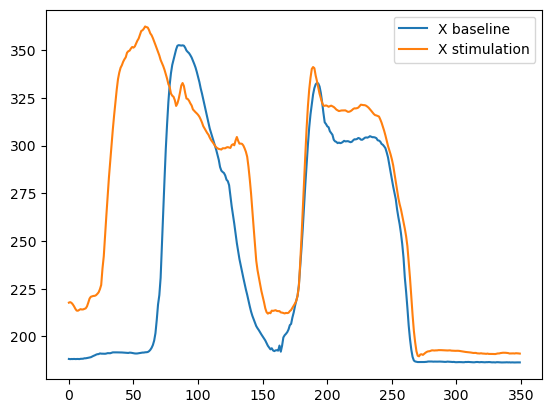

In [18]:
plt.plot(td_base.x[0][2250:2250+350,5], label = 'X baseline')
plt.plot(td_stim.x[0][2850:2850+350,5], label = 'X stimulation')
plt.legend()

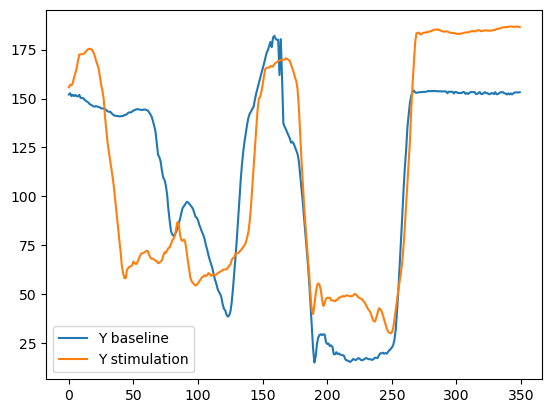

In [19]:
plt.plot(td_base.y[0][2250:2250+350,5], label = 'Y baseline')
plt.plot(td_stim.y[0][2850:2850+350,5], label = 'Y stimulation')
plt.legend()

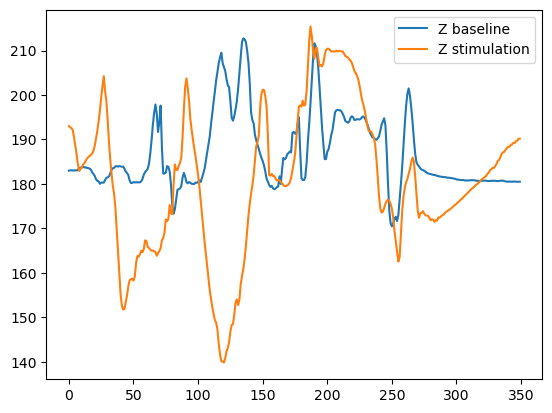

In [20]:
plt.plot(td_base.z[0][2250:2250+350,5], label = 'Z baseline')
plt.plot(td_stim.z[0][2850:2850+350,5], label = 'Z stimulation')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


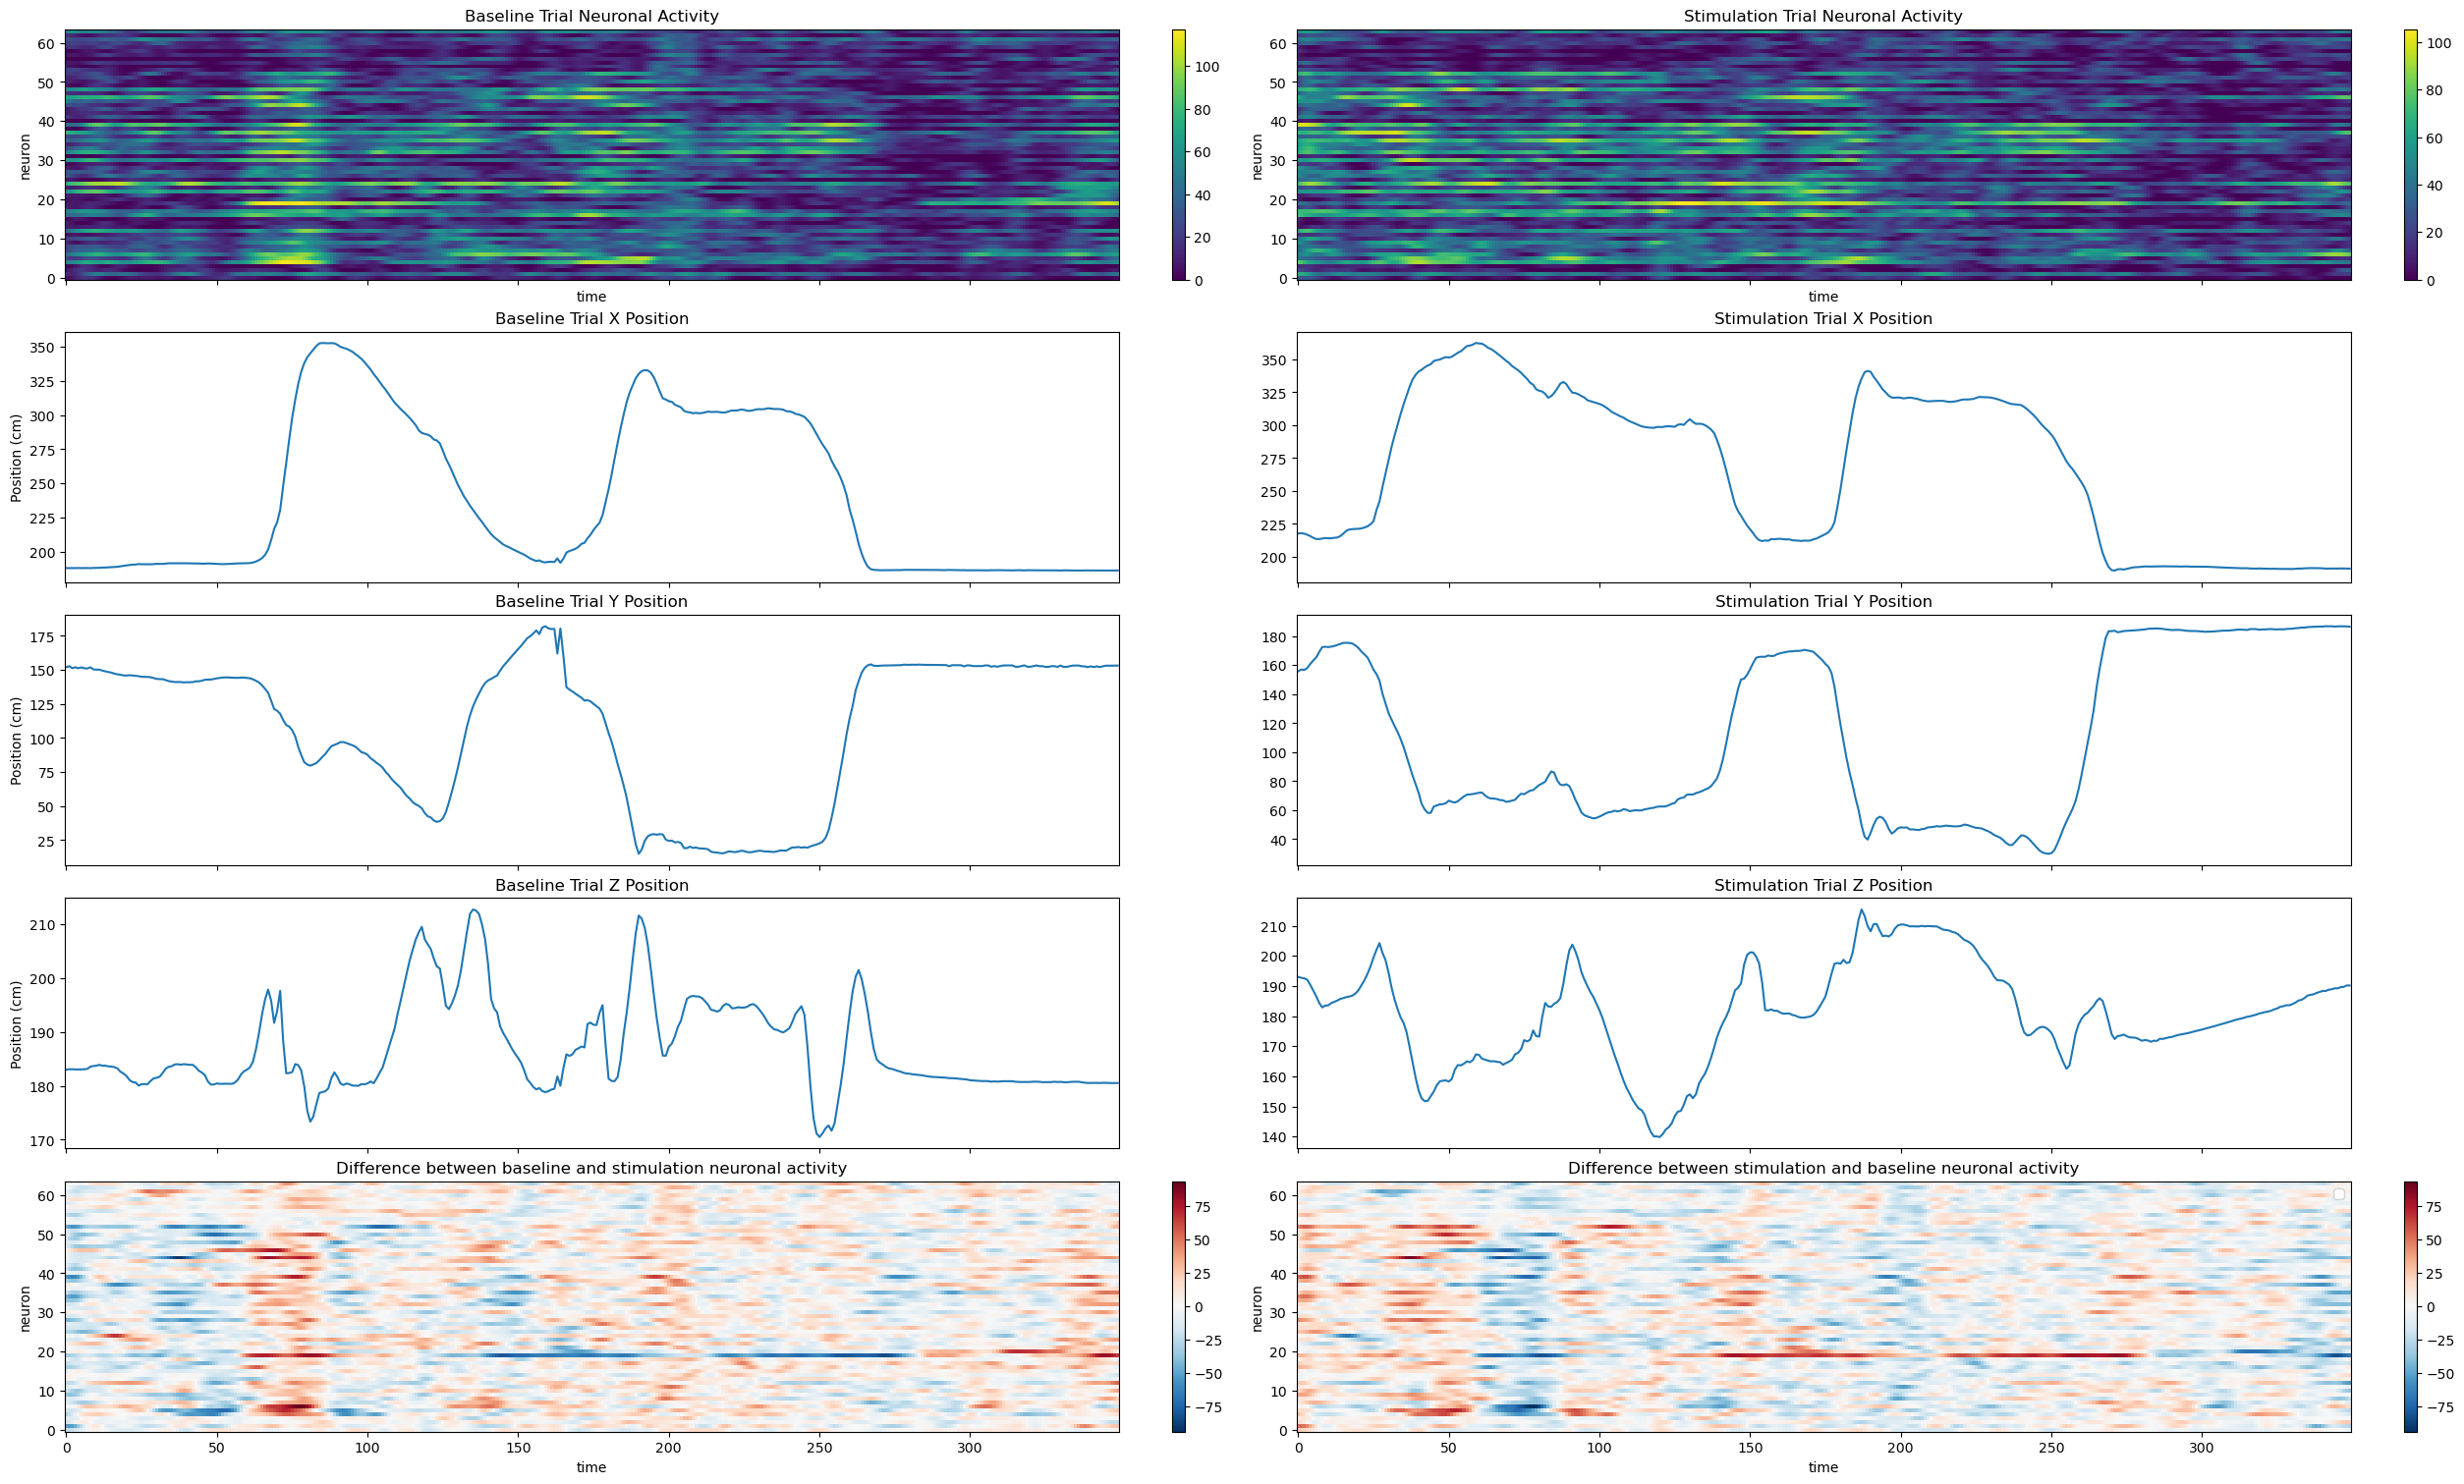

In [21]:
fig, ax = plt.subplots(figsize = (25, 15), ncols = 2, nrows = 5, constrained_layout=True, sharex = True) #, width_ratios=[2, 3])

xr.DataArray(td_base.M1_rates[0][2250:2250+350,:], dims = ['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[0,0])
xr.DataArray(td_stim.M1_rates[0][2850:2850+350,:],  dims = ['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[0,1])
ax[0,0].set_title('Baseline Trial Neuronal Activity')
ax[0,1].set_title('Stimulation Trial Neuronal Activity')

ax[1,0].set_xlim(0,350)  # Adjust x-axis limits
ax[1,1].set_xlim(0,350)  # Adjust x-axis limits
ax[1,0].plot(td_base.x[0][2250:2250+350,5],  label = 'X baseline')
ax[1,1].plot(td_stim.x[0][2850:2850+350,5],  label = 'X stimulation')
ax[1,0].set_title('Baseline Trial X Position')
ax[1,1].set_title('Stimulation Trial X Position')
ax[1,0].set_ylabel('Position (cm)')

ax[2,0].set_xlim(0,350)  # Adjust x-axis limits
ax[2,1].set_xlim(0,350)  # Adjust x-axis limits
ax[2,0].plot(td_base.y[0][2250:2250+350,5],  label = 'Y baseline')
ax[2,1].plot(td_stim.y[0][2850:2850+350,5],  label = 'Y stimulation')
ax[2,0].set_title('Baseline Trial Y Position')
ax[2,1].set_title('Stimulation Trial Y Position')
ax[2,0].set_ylabel('Position (cm)')

ax[3,0].set_xlim(0,350)  # Adjust x-axis limits
ax[3,1].set_xlim(0,350)  # Adjust x-axis limits
ax[3,0].plot(td_base.z[0][2250:2250+350,5],  label = 'Z baseline')
ax[3,1].plot(td_stim.z[0][2850:2850+350,5],  label = 'Z stimulation')
ax[3,0].set_title('Baseline Trial Z Position')
ax[3,1].set_title('Stimulation Trial Z Position')
ax[3,0].set_ylabel('Position (cm)')

xr.DataArray(td_base.M1_rates[0][2250:2250+350,:]-td_stim.M1_rates[0][2850:2850+350,:], dims = ['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[4,0])
xr.DataArray(td_stim.M1_rates[0][2850:2850+350,:]-td_base.M1_rates[0][2250:2250+350,:],  dims = ['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[4,1])
ax[4,0].set_title('Difference between baseline and stimulation neuronal activity')
ax[4,1].set_title('Difference between stimulation and baseline neuronal activity')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


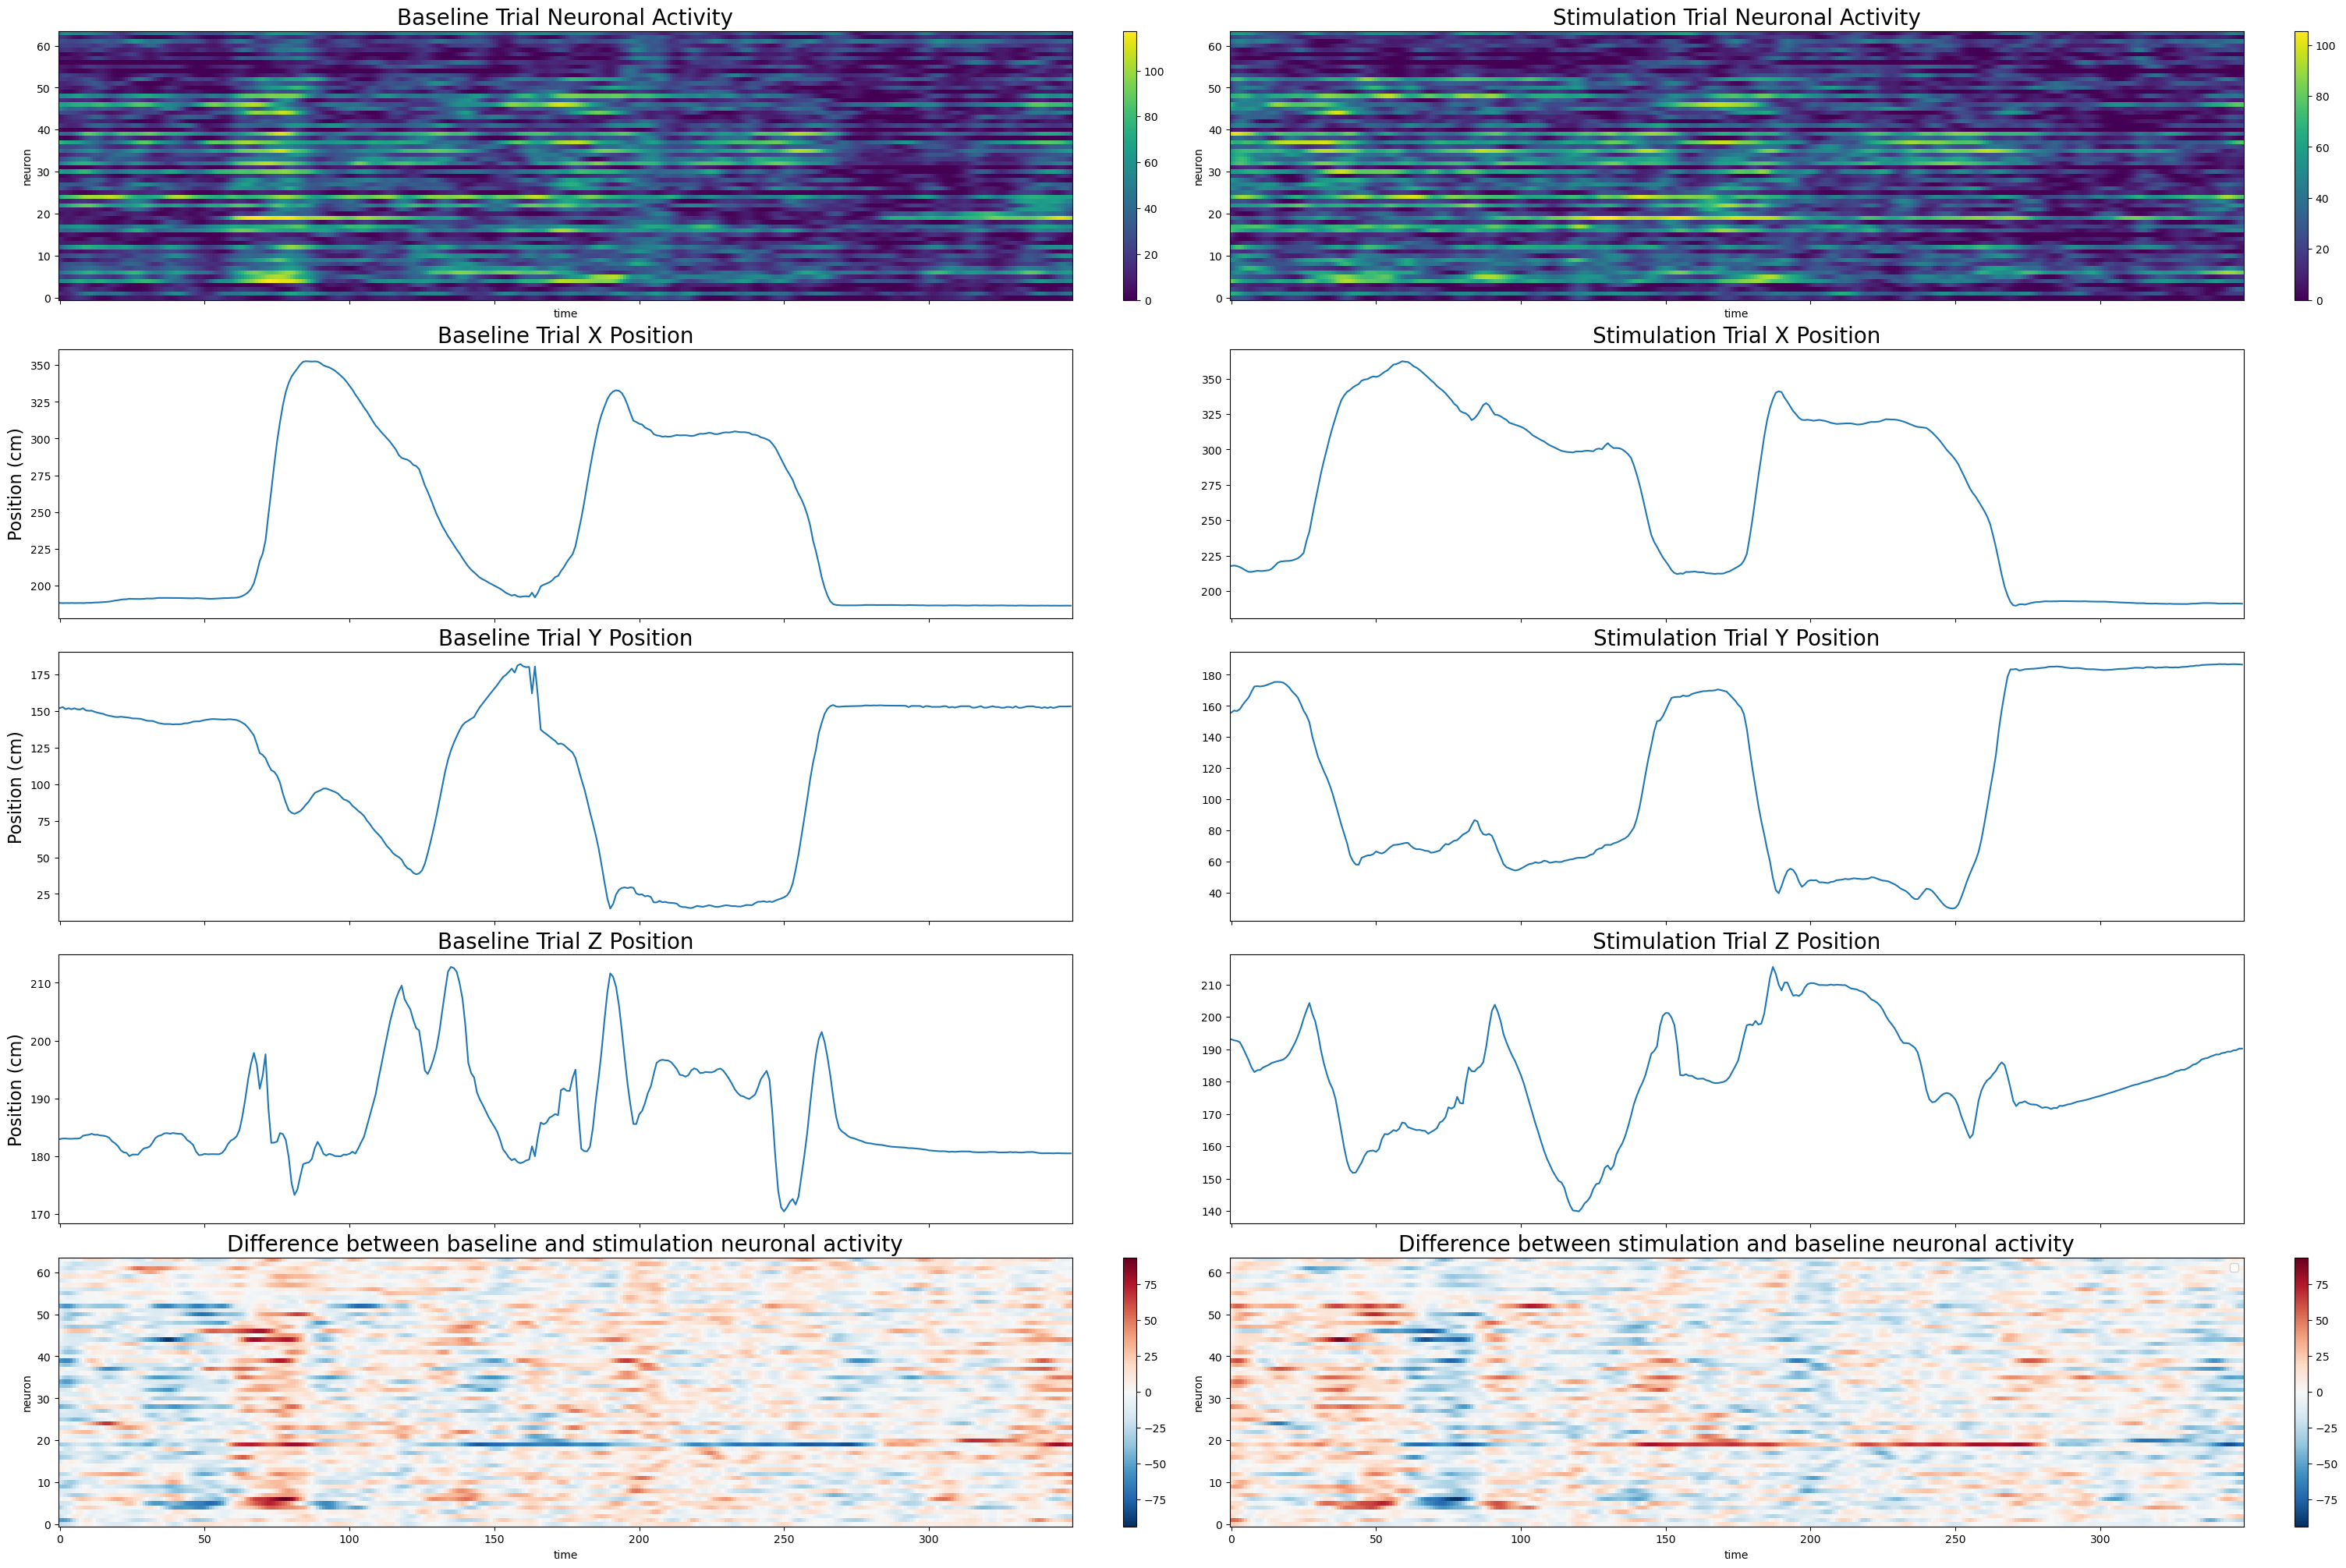

In [25]:
import matplotlib.pyplot as plt
import xarray as xr

fig, ax = plt.subplots(figsize=(30, 20), ncols=2, nrows=5, constrained_layout=True, sharex=True) 

xr.DataArray(td_base.M1_rates[0][2250:2250+350, :], dims=['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[0, 0])
xr.DataArray(td_stim.M1_rates[0][2850:2850+350, :], dims=['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[0, 1])
ax[0, 0].set_title('Baseline Trial Neuronal Activity', fontsize=20)
ax[0, 1].set_title('Stimulation Trial Neuronal Activity', fontsize=20)

ax[1, 0].set_xlim(0, 350)  
ax[1, 1].set_xlim(0, 350)  
ax[1, 0].plot(td_base.x[0][2250:2250+350, 5], label='X baseline')
ax[1, 1].plot(td_stim.x[0][2850:2850+350, 5], label='X stimulation')
ax[1, 0].set_title('Baseline Trial X Position', fontsize=20)
ax[1, 1].set_title('Stimulation Trial X Position', fontsize=20)
ax[1, 0].set_ylabel('Position (cm)', fontsize=16)

ax[2, 0].set_xlim(0, 350)  
ax[2, 1].set_xlim(0, 350)  
ax[2, 0].plot(td_base.y[0][2250:2250+350, 5], label='Y baseline')
ax[2, 1].plot(td_stim.y[0][2850:2850+350, 5], label='Y stimulation')
ax[2, 0].set_title('Baseline Trial Y Position', fontsize=20)
ax[2, 1].set_title('Stimulation Trial Y Position', fontsize=20)
ax[2, 0].set_ylabel('Position (cm)', fontsize=16)

ax[3, 0].set_xlim(0, 350)  
ax[3, 1].set_xlim(0, 350)  
ax[3, 0].plot(td_base.z[0][2250:2250+350, 5], label='Z baseline')
ax[3, 1].plot(td_stim.z[0][2850:2850+350, 5], label='Z stimulation')
ax[3, 0].set_title('Baseline Trial Z Position', fontsize=20)
ax[3, 1].set_title('Stimulation Trial Z Position', fontsize=20)
ax[3, 0].set_ylabel('Position (cm)', fontsize=16)

xr.DataArray(td_base.M1_rates[0][2250:2250+350, :] - td_stim.M1_rates[0][2850:2850+350, :], dims=['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[4, 0])
xr.DataArray(td_stim.M1_rates[0][2850:2850+350, :] - td_base.M1_rates[0][2250:2250+350, :], dims=['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[4, 1])
ax[4, 0].set_title('Difference between baseline and stimulation neuronal activity', fontsize=20)
ax[4, 1].set_title('Difference between stimulation and baseline neuronal activity', fontsize=20)

plt.legend()
plt.show()
